In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import json
import numpy as np
from operator import itemgetter
import pickle as pkl
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import matplotlib as mpl
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')
import matplotlib.pyplot as plt

np.seterr(divide='ignore') # masks log(0) errors

no display found. Using non-interactive Agg backend


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
from hybrid.hmm.multiple import FullGaussianHMM

The default DNN set-up should take ~40 seconds/epoch on a GPU (and ~350 secconds/epoch on a CPU).

Performance (WER) on test set:   

Baseline performance of the GMM-HMM model   
24.55%

Performance of the DNN-HMM model with normalized emission probabilities   
20.45%

Performance of the DNN-HMM model with unnormalized emission probabilities   
18.18%

## Training a multiple digit GMM-HMM model
NOTE: You are not expected to run/tune this part as the trained FullGaussianHMM model file is provided. The provided model is designed to have 15 states for each digit and 3 additional states for start, pause, and end. Feel free to look through hybrid/hmm/multiple.py to see how we can string single-digit HMMs to obtain the one that can model multiple-digit sequences.

In [3]:
# """
# Multiple Digit HMM: training two-digit sequences
# """
# data_multiple_digit = np.load("hybrid/data/mfccs/mfccs_multiple.npz", allow_pickle=True)
# full_model = FullGaussianHMM(data_multiple_digit["Xtrain"], "hybrid/hmm/models/single_digit_model.pkl")

# n_iter = 15

# print("Training HMM")
# for i in range(n_iter):
#     print("starting iteration {}...".format(i + 1))
#     full_model.train(data_multiple_digit["Xtrain"], data_multiple_digit["Ytrain"])
        
# print("Testing HMM")
# test_wer = full_model.test(data_multiple_digit["Xtest"], data_multiple_digit["Ytest"])
# print("{:.2f}% WER".format(test_wer * 100.))

# with open("hybrid/hmm/models/multiple_digit_model.pkl", "wb") as f:
#     pkl.dump(full_model, f)

## Saving the optimal state sequences
Save the optimal state label per framee using the trained GMM-HMM model. Complete the # TODO in force_align function

In [4]:
def force_align(X, Y, hmm_gmm_model):
    """
    Force align using Viterbi to get the hidden state sequence for each (X, Y) pair.
    ------
    input:
    X: list of 2d-arrays of shape (Tx, 13): list of single digit MFCC features
    Y: digit sequence
    hmm_gmm_model: load the trained model
    ------
    Returns a list of utterence-wise hidden state sequences
    """
    digit_states_total = hmm_gmm_model.digit_states_total
    start_states, stop_states = hmm_gmm_model.start_states, hmm_gmm_model.stop_states
    begin_sil_id, pause_id, end_sil_id = hmm_gmm_model.begin_sil, hmm_gmm_model.pause, hmm_gmm_model.end_sil
    A_estimate, pi_estimate = hmm_gmm_model.A, hmm_gmm_model.pi
    state_seqs = []
    for ii, (x, y) in enumerate(zip(X, Y)):

        y = np.array([0 if yy == 'o' else int(yy) for yy in y], dtype=np.int32)

        # TODO: edit A_estimate appropriately to enable decoding for the ground-truth labels
        A_estimate[begin_sil_id] = 0
        A_estimate[pause_id] = 0
        for idx, yy in enumerate(y):
            if idx == 0:
                A_estimate[begin_sil_id, start_states[yy]] = 1
            else:
                A_estimate[pause_id, start_states[yy]] = 1
            start, stop = start_states[yy], stop_states[yy]
            A_estimate[start: stop + 1] = 0
            A_estimate[start: stop, start + 1: stop + 1] = np.eye(stop - start)
            if idx == len(y) - 1:
                A_estimate[stop_states[yy], end_sil_id] = 1
            else:
                A_estimate[stop_states[yy], pause_id] = 1

#         test_force_align(y, A_estimate, start_states, stop_states, begin_sil_id, pause_id, end_sil_id)

        log_pi = np.log(pi_estimate)
        log_A = np.log(A_estimate)
        log_B = hmm_gmm_model.get_emissions(x)

        q, log_prob = hmm_gmm_model.viterbi(log_pi, log_A, log_B) 
        state_seqs.append(q)

    return state_seqs

In [5]:
# sanity-check force_align
def test_force_align(y, mat, start_states, stop_states, begin_sil_id, pause_id, end_sil_id):
    assert np.allclose(mat.sum(axis=1), 1)  # row-stochastic
    for idx, yy in enumerate(y):
        if idx == 0:
            assert mat[begin_sil_id, start_states[yy]] == 1
        else:
            assert mat[pause_id, start_states[yy]] == 1
        start, stop = start_states[yy], stop_states[yy]
        assert np.alltrue(mat[start : stop, start + 1 : stop + 1] == np.eye(stop - start))
        if idx == len(y) - 1:
            assert mat[stop_states[yy], end_sil_id] == 1
        else:
            assert mat[stop_states[5], pause_id] == 1

In [6]:
# data_multiple_digit = np.load("hybrid/data/mfccs/mfccs_multiple.npz", allow_pickle=True)
# with open("hybrid/hmm/models/multiple_digit_model.pkl", "rb") as f:
#     hmm_gmm_model = pkl.load(f)
    
# state_seq_train = force_align(data_multiple_digit["Xtrain"], data_multiple_digit["Ytrain"], hmm_gmm_model)
# state_seq_dev = force_align(data_multiple_digit["Xdev"], data_multiple_digit["Ydev"], hmm_gmm_model)
# state_seq_test = force_align(data_multiple_digit["Xtest"], data_multiple_digit["Ytest"], hmm_gmm_model)
# seqDict = {'Ytrain': state_seq_train, 'Ydev': state_seq_dev, 'Ytest': state_seq_test, 'total_states': hmm_gmm_model.total}
# np.savez_compressed('hybrid/data/state_seq/state_seq.npz', **seqDict)

## Training a DNN frame classifier

In [7]:
from hybrid.dnn.loader import DataLoader

In [8]:
with open("hybrid/dnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)

np.random.seed(config["seed"])
torch.manual_seed(config["seed"])

data_cfg = config["data"]
model_cfg = config["model"]
opt_cfg = config["optimizer"]
out_cfg = config["output"]
save_model_fn = os.path.join(out_cfg["save_dir"], "dnn_model")

data_mfccs = np.load(data_cfg["mfcc"], allow_pickle=True)
state_seq = np.load(data_cfg["state_seq"], allow_pickle=True)

print("Preparing data...\n")
data_ldr = DataLoader(data_cfg)
train_features, train_labels, train_labels_onehot, train_utt_to_frames = data_ldr.prepare_data('train')
dev_features, dev_labels, dev_labels_onehot, dev_utt_to_frames = data_ldr.prepare_data('dev')
test_features, test_labels, test_labels_onehot, test_utt_to_frames = data_ldr.prepare_data('test')

feat_dim = (data_ldr.context_size+1)*data_ldr.mfcc_dim
n_states = data_ldr.n_states

Preparing data...



In [9]:
class FeedForward(nn.Module):

    def __init__(self, feat_dim, n_states, hidden_dim, n_layers, dropout):
        """
        Initialized feed forward neural network model.
        ---
        feat_dim: input feature dimension
        n_states: size of the output
        hidden_dim: dimension of the hidden layers
        n_layers: number of layers
        dropout: dropout probabilty for the dropout layer
        """
        super().__init__()

        self.n_layers = n_layers
        self.fc_input = nn.Linear(feat_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, n_states)
        self.fc_hidden_list = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim)]*n_layers)
        self.nl = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        """
        Forward pass for the feedforward network
        """
        x = self.nl(self.fc_input(x))
        for i in range(self.n_layers):
            x = self.nl(self.fc_hidden_list[i](x))
        output = F.leaky_relu(self.fc_output(x))

        return output

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

In [32]:
def train(classifier, epoch, batch_size, device, loss_func, optim):
    """
    Training the classifier on frame level labels
    """
    classifier.train()
    perm = np.random.permutation(train_features.shape[0])
    train_loss, pred_multi, gt_multi = [], [], []
    n_iter = 0
    start = time.time()
    time_per_iter = [0]*4
    for i in range(0, len(perm), batch_size):
        idx = perm[i:i+batch_size]
        train_Xs = torch.tensor(train_features[idx], dtype=torch.float32).to(device)
        train_Ys = torch.tensor(train_labels[idx], dtype=torch.long).to(device)
        pred_Ys = classifier(train_Xs)
        loss = loss_func(pred_Ys, train_Ys)
        optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), 5.0)
        optim.step()
        train_loss.append(loss.cpu().item())
        pred_multi.append(np.argmax(pred_Ys.cpu().data.numpy(), axis=1))
        gt_multi.append(train_Ys.cpu().data.numpy())
    pred_multi, gt_multi = np.concatenate(pred_multi, axis=0), np.concatenate(gt_multi, axis=0)
    accuracy = 100*len(np.where((pred_multi - gt_multi)==0)[0])/len(pred_multi)
    mean_loss = np.mean(train_loss)
    print("Epoch: %d, Training loss: %.2f, Accuracy: %.2f, Time elapsed: %.2f seconds" % (epoch, mean_loss, accuracy, time.time() - start))

    return accuracy, mean_loss

def test(features, labels, test_batch_size, device, loss_func, classifier_test=None):
    """
    Training the classifier on frame level labels
    """
    if classifier_test is None:
        classifier_test = torch.load(save_model_fn)
    classifier_test.eval()
    test_loss, pred_multi, gt_multi = [], [], []
    n_iter = 0
    start = time.time()
    for i in range(0, len(features), test_batch_size):
        n_iter += 1
        idx = list(range(i, min(i+test_batch_size, len(features))))
        test_Xs = torch.tensor(features[idx], dtype=torch.float32).to(device)
        test_Ys = torch.tensor(labels[idx], dtype=torch.long).to(device)
        pred_Ys = classifier_test(test_Xs)
        loss = loss_func(pred_Ys, test_Ys)
        test_loss.append(loss.cpu().item())
        pred_multi.append(np.argmax(pred_Ys.cpu().data.numpy(), axis=1))
        gt_multi.append(test_Ys.cpu().data.numpy())

    pred_multi, gt_multi = np.concatenate(pred_multi, axis=0), np.concatenate(gt_multi, axis=0)
    accuracy = 100*len(np.where((pred_multi - gt_multi)==0)[0])/len(pred_multi)

    print("Dev Accuracy: %.2f, Time elapsed: %.2f seconds" % (accuracy, time.time() - start))

    return accuracy

def main_train(classifier, batch_size, test_batch_size, tot_epoch, device, loss_func, optim, meta):
    print("Training begins ...\n")
    best_accuracy = 0
    plotting = {'train_loss': [], 'train_accu': [], 'dev_accu': []}
    for epoch in range(tot_epoch):
        train_accuracy, train_loss = train(classifier, epoch, batch_size, device, 
                                           loss_func, optim)
        dev_accuracy = test(dev_features, dev_labels, test_batch_size, device, loss_func, classifier)
        print('Epoch {}: train_loss: {}, train_accuracy: {}, dev_accuracy: {}'.format(
            epoch, train_loss, train_accuracy, dev_accuracy))
        
        plotting['train_loss'].append(train_loss)
        plotting['train_accu'].append(train_accuracy)
        plotting['dev_accu'].append(dev_accuracy)
        
        if dev_accuracy > best_accuracy:
            best_epoch = epoch
            best = '{}-{}.pkl'.format(save_model_fn, meta)
            torch.save(classifier, best)
            print('Saved model:', best)
            best_accuracy = dev_accuracy
    print('\nBest dev accuracy: %.2f at epoch: %d' % (best_accuracy, best_epoch))
    return plotting

def main_test(test_batch_size, device):
    accuracy = test(test_features, test_labels, device, test_batch_size, loss_func)
    print('\nAccuracy on test set: %.2sf' % (accuracy))

In [58]:
# plotting helper
def plot_loss_accu(best, plotting, xlabel='# epochs', xticks=None):
    plt.suptitle(best)
    plt.subplot(1, 2, 1)
    if xticks is None:
        plt.plot(plotting['train_loss'], label='train_loss')
    else:
        plt.plot(xticks, plotting['train_loss'], label='train_loss')
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel('train_loss')
    plt.subplot(1, 2, 2)
    if xticks is None:
        plt.plot(plotting['dev_accu'], label='dev_accu')
        plt.plot(plotting['train_accu'], label='train_accu')
    else:
        plt.plot(xticks, plotting['dev_accu'], label='dev_accu')
        plt.plot(xticks, plotting['train_accu'], label='train_accu')    
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel('accuracy')
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig('figures/' + best + '.png')
    plt.show()

In [36]:
# TODO: tune on the dev set
# may want to set up function or chunk of code here to perform tuning
# call train on training set, call test on dev, save/plot/compare results
def tune(hyperparams):
    tot_epoch = opt_cfg["max_epochs"]
    hidden_dim = hyperparams.get('hidden_dim', model_cfg["hidden_dim"])
    n_layers = hyperparams.get('n_layers', model_cfg["n_layers"])
    dropout = hyperparams.get('dropout_prob', model_cfg["dropout_probability"])

    batch_size = hyperparams.get('batch_size', opt_cfg["batch_size"])
    test_batch_size = opt_cfg["test_batch_size"]
    
    print('\n\nModel Configuration ep {}, hid {}, n_layers {}, dropout {}, batch {}'.format(
    tot_epoch, hidden_dim, n_layers, dropout, batch_size))

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device == 'cuda':
        torch.backends.cudnn.deterministic = True

    classifier = FeedForward(feat_dim, n_states, hidden_dim, n_layers, dropout).to(device)
    # classifier.apply(init_weights)
    loss_function = nn.CrossEntropyLoss()
    optimizer = getattr(torch.optim, opt_cfg["type"])(list(classifier.parameters()))

    meta = '+'.join([str(elm) for elm in [tot_epoch, hidden_dim, n_layers, dropout, batch_size]])
    plotting = main_train(classifier, batch_size, test_batch_size, tot_epoch, device, 
               loss_function, optimizer, meta)
    
    return meta, plotting

## Loss and Accuracy vs. Epochs

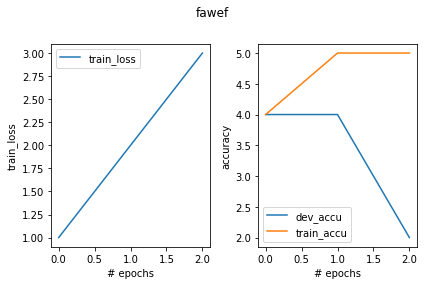

In [59]:
# default config
best, plotting = tune({})
plot_loss_accu(best, plotting)

## Tuning Experiments

In [62]:
def experiment(param_name, param_range):
    data = {'train_loss': [], 'train_accu': [], 'dev_accu': []}
    for param in param_range:
        hp = {param_name: param}
        _, plotting = tune(hp)
        # record best dev accuracy
        idx = np.argmax(plotting['dev_accu'])
        for k in data:
            data[k].append(plotting[k][idx])
    #     plot_wer_loss(best, plotting)
    plot_loss_accu(param_name, data, xlabel=param_name, xticks=param_range)

In [63]:
# tune dropout
experiment('dropout_prob', [0.2, 0.4, 0.6, 0.8])



Model Configuration ep 10, hid 512, n_layers 1, dropout 0.2, batch 8
Training begins ...



KeyboardInterrupt: 

In [ ]:
# # tune n_layers
# experiment('n_layers', [1, 2])

Save log-emission probabilities using the best model saved

In [ ]:
def get_log_emission(utt_to_frames_dict, features, prior, temp_parameter, best_model_path):
    """
    Save posteriors using the trained model
    """
    classifier_eval = torch.load(best_model_path)
    classifier_eval.eval()
    log_emission = []
    n_iter = 0
    for utt_idx in range(len(utt_to_frames_dict)):
        frame_id = utt_to_frames_dict[utt_idx]
        log_emission_utt = []
        for i in range(0, len(frame_id), batch_size):
            idx = frame_id[i:i+batch_size]
            Xs = torch.tensor(itemgetter(*idx)(features), dtype=torch.float32).to(device)
            log_pred_Ys = F.log_softmax(classifier_eval(Xs), dim=1).cpu().data.numpy()
            log_emission_utt.append(log_pred_Ys  - temp_parameter*np.log(prior))
        log_emission_utt = np.concatenate(log_emission_utt, axis=0)
        log_emission.append(log_emission_utt)

    return log_emission

In [ ]:
# temp_parameter = out_cfg["temp_parameter"]
# print("Saving log emissions for temperature %.1f ...\n" % (temp_parameter))
# prior = data_ldr.get_prior()
# train_log_emission =  get_log_emission(train_utt_to_frames, train_features, prior, temp_parameter, save_model_fn)
# dev_log_emission = get_log_emission(dev_utt_to_frames, dev_features, prior, temp_parameter, save_model_fn)
# test_log_emission = get_log_emission(test_utt_to_frames, test_features, prior, temp_parameter, save_model_fn)
# log_emission_dict = {'Ytrain': train_log_emission, 'Ydev': dev_log_emission, 'Ytest': test_log_emission}
# np.savez_compressed(os.path.join('hybrid/data/log_emission/log_emission_'+str(temp_parameter)+'.npz'), **log_emission_dict)


## HMM inference using the posterior from neural network

In [ ]:
# data_multiple_digit = np.load("hybrid/data/mfccs/mfccs_multiple.npz", allow_pickle=True)

# with open("hybrid/hmm/models/multiple_digit_model.pkl", "rb") as f:
#     full_model_trained = pkl.load(f)

# log_emission_1 = np.load('hybrid/data/log_emission/log_emission_1.0.npz', allow_pickle=True)
# log_emission_0 = np.load('hybrid/data/log_emission/log_emission_0.0.npz', allow_pickle=True)
    
# def get_test_wer(model, posterior=None):
#     test_wer = model.test(data_multiple_digit["Xtest"], data_multiple_digit["Ytest"], posterior)
#     print("{:.2f}% TEST WER".format(test_wer * 100.))

# print('Baseline performance of the trained model')
# get_test_wer(full_model_trained)

# print('Performance of the trained model with normalized emission probabilities')
# get_test_wer(full_model_trained, log_emission_1["Ytest"])

# print('Performance of the trained model with unnormalized emission probabilities')
# get_test_wer(full_model_trained, log_emission_0["Ytest"])